In [112]:
import sys
sys.path.append('/home/onyxia/work/libsigma')
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import read_and_write as rw
from osgeo import gdal, osr
sys.path.append('/home/onyxia/work/Projet_Teledetection_UE901_21')
import my_function as mf
import numpy as np



In [91]:
# Chargement des strates d'échantillons
fichier_strates = '/home/onyxia/work/data/projet_eval/PI_strates_pyrenees_32630.shp'
gdf_strates = gpd.read_file(fichier_strates)
#print('type of gdf : ', type(gdf))
gdf_strates

,id,strate,comment,geometry
0,1,3,lande basse,"POLYGON ((686851.853 4758529.727, 686852.251 4..."
1,2,3,lande basse,"POLYGON ((686804.228 4758526.185, 686806.22 47..."
2,3,3,lande basse,"POLYGON ((686820.534 4758490.129, 686821.53 47..."
3,4,3,lande basse + blocs,"POLYGON ((686829.616 4758475.777, 686830.015 4..."
4,5,3,lande basse + blocs,"POLYGON ((686801.094 4758794.649, 686802.091 4..."
...,...,...,...,...
201,62,1,None,"POLYGON ((703448.828 4761113.693, 703455.803 4..."
202,63,1,None,"POLYGON ((703453.571 4761082.183, 703454.169 4..."
203,64,1,None,"POLYGON ((703390.943 4761075.531, 703391.74 47..."
204,65,1,None,"POLYGON ((703517.708 4760288.2, 703517.907 476..."


strate
1    28
2    69
3    78
4    31
Name: count, dtype: int64


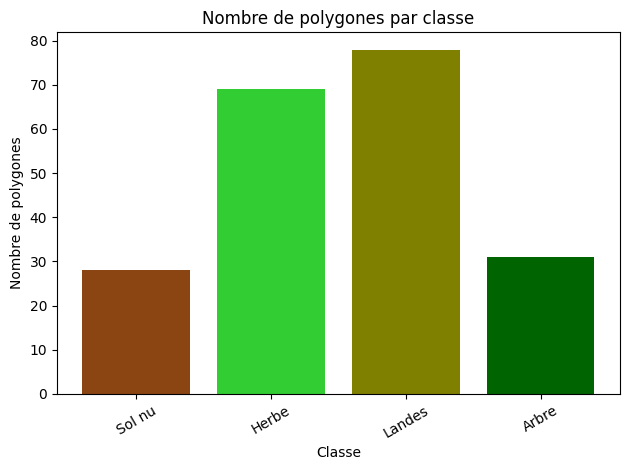

<Figure size 640x480 with 0 Axes>

In [92]:
#Nombre de polygones par classe et vous commenterez brièvement les résultats obtenus;

# Nom du champ de classe 
champ_classe = "strate"

# Nomenclature des classes et couleurs
class_names = {
    1: "Sol nu",
    2: "Herbe",
    3: "Landes",
    4: "Arbre"
}

class_colors = {
    1: "saddlebrown",
    2: "limegreen",
    3: "olive",
    4: "darkgreen"
}

# Comptage des polygones par classe
counts_poly = gdf_strates[champ_classe].value_counts().sort_index()

# Remplacer les codes par les noms et couleurs
labels = [class_names[c] for c in counts_poly.index]
colors = [class_colors[c] for c in counts_poly.index]

# affficher nombre de polygone par classe
print(counts_poly)

# diagramme en bar des nombres de polygones par classe
plt.figure()
plt.bar(labels, counts_poly.values, color=colors)
plt.xlabel("Classe")
plt.ylabel("Nombre de polygones")
plt.title("Nombre de polygones par classe")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Enregistrement dans le répertoire figure
plt.savefig("/home/onyxia/work/Projet_Teledetection_UE901_21/resultats/figure/diag_baton_nb_poly_by_class.png", dpi=300)

# Commentaires
Les résultats montrent une dominance de la classe Landes (classe 3), qui possède le plus grand nombre de polygones. La classe Herbe (classe 2) arrive en seconde position, suivie par la classe Arbre (classe 4). En revanche, la classe Sol nu (classe 1) est faiblement représentée, ce qui indique une présence limitée de surfaces nues dans les échantillons analysés.

EPSG:32630
strate
1    28.171484
2    71.693679
3    80.374296
4    26.886401
Name: surface_m2, dtype: float64


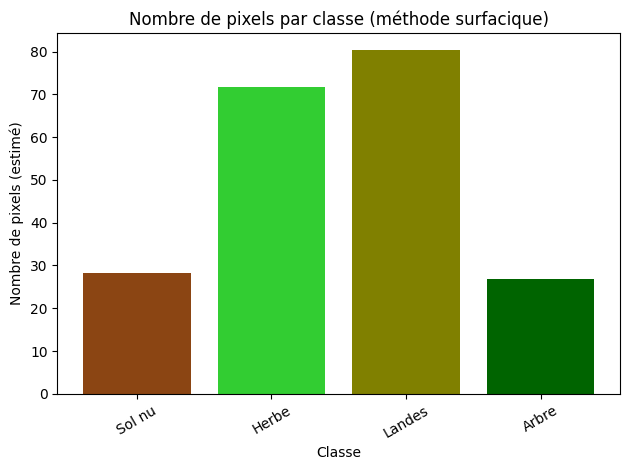

<Figure size 640x480 with 0 Axes>

In [93]:
# Nombre de pixel par classe et vous commenterez brièvement les résultats obtenus.
# Dictionnaires
class_names = {
    1: "Sol nu",
    2: "Herbe",
    3: "Landes",
    4: "Arbre"
}

class_colors = {
    1: "saddlebrown",
    2: "limegreen",
    3: "olive",
    4: "darkgreen"
}


champ_classe = "strate"

# Vérifier que le CRS est projeté (en mètres)
print(gdf_strates.crs)

# Calcul de la surface des polygones (en m²)
gdf_strates["surface_m2"] = gdf_strates.geometry.area

# Surface d'un pixel (à adapter à ton image)
# Exemple : image à 10 m
pixel_size = 10  # mètres
pixel_area = pixel_size ** 2  # m²

# Surface totale par classe
surface_par_classe = gdf_strates.groupby(champ_classe)["surface_m2"].sum().sort_index()

# Conversion surface → nombre de pixels
nb_pixels = surface_par_classe / pixel_area

# Préparer affichage
labels = [class_names[c] for c in nb_pixels.index]
colors = [class_colors[c] for c in nb_pixels.index]

print(nb_pixels)
# Diagramme
plt.figure()
plt.bar(labels, nb_pixels.values, color=colors)
plt.xlabel("Classe")
plt.ylabel("Nombre de pixels (estimé)")
plt.title("Nombre de pixels par classe (méthode surfacique)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Enregistrement dans le répertoire figure
plt.savefig("/home/onyxia/work/Projet_Teledetection_UE901_21/resultats/figure/diag_baton_nb_pix_by_class.png", dpi=300)


In [94]:

pyr_b03 = '/home/onyxia/work/data/projet_eval/pyrenees_24-25_B03.tif'
pyr_b05 = '/home/onyxia/work/data/projet_eval/pyrenees_24-25_B05.tif'

open_pyr_b03 = rw.open_image(pyr_b03)
open_pyr_b05 = rw.open_image(pyr_b05)

dim_b03 = rw.get_image_dimension(open_pyr_b03)

dim_b05 = rw.get_image_dimension(open_pyr_b05)

rw.get_origin_coordinates(open_pyr_b05)
#rw.get_pixel_size(open_pyr_b05)

print(open_pyr_b03)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f5e81045560> >


In [95]:
# vérification de la résolution sapatiale à 10m
print(rw.get_pixel_size(open_pyr_b03))
print(rw.get_pixel_size(open_pyr_b05))

(10.0, -10.0)
(10.0, -10.0)


In [96]:
# Vérification du système de projection  WGS 84 / UTM zone 30N (EPSG:32630)
print(open_pyr_b03.GetProjection())
print(open_pyr_b05.GetProjection())

PROJCS["WGS 84 / UTM zone 30N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32630"]]
PROJCS["WGS 84 / UTM zone 30N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-3],PARAMETER["sc

In [97]:
band3 = open_pyr_b03.GetRasterBand(1).ReadAsArray().astype(float)
band5 = open_pyr_b05.GetRasterBand(1).ReadAsArray().astype(float)

In [101]:
ari = (1/band3 - 1/band5) / (1/band3 + 1/band5)

# --- 4. Remplacer les valeurs invalides par Nodata ---
ari[np.isnan(ari)] = -9999
ari[np.isinf(ari)] = -9999

In [113]:
# --- 5. Préparer le nouveau fichier TIFF ---
driver = gdal.GetDriverByName('GTiff')
rows, cols = ari.shape
out_ds = driver.Create(
    '/home/onyxia/work/Projet_Teledetection_UE901_21/resultats/figure/ARI_serie_temp.tif',
    cols,
    rows,
    1,
    gdal.GDT_Float32
)


# --- 6. Définir la projection et la transformation géographique ---
# On récupère la géotransform et la projection de la bande 3 comme base
geo_transform = open_pyr_b03.GetGeoTransform()
proj = open_pyr_b03.GetProjection()

# Si tu veux forcer EPSG:32630 :
srs = osr.SpatialReference()
srs.ImportFromEPSG(32630)
proj = srs.ExportToWkt()

# Pour forcer la résolution 10m, tu peux ajuster le GeoTransform :
# Ici on suppose que l'image source est déjà en 10m ; sinon :
# geo_transform = (geo_transform[0], 10, 0, geo_transform[3], 0, -10)

out_ds.SetGeoTransform(geo_transform)
out_ds.SetProjection(proj)

# --- 7. Écrire les données et définir le NoData ---
out_band = out_ds.GetRasterBand(1)
out_band.WriteArray(ari)
out_band.SetNoDataValue(-9999)

# --- 8. Sauvegarder et fermer ---
out_band.FlushCache()
out_ds = None
band3_ds = None
band5_ds = None

In [85]:
print(gdal.GetDataTypeName(ds_band_03.GetRasterBand(1).DataType))

Float64
